# Domain Analysis

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import sys
sys.path.append("../../..")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import asyncio
from collections import defaultdict
from concurrent.futures import ThreadPoolExecutor
import ipaddress
import os.path

import matplotlib
import networkx as nx

matplotlib.rcParams['figure.figsize'] = (9.5, 8)
EXECUTOR = ThreadPoolExecutor()
LOOP = asyncio.new_event_loop()
EXECUTOR.submit(LOOP.run_forever)

<Future at 0x7fe00d0a4b70 state=running>

## Load Full DNS Graph

In [37]:
from netanalysis.dns.analysis.analysis_app import AnalysisApp

app = AnalysisApp(os.path.join(os.getcwd(), "..", "..", "..", "ooni_data"))

IntProgress(value=0, description='Loading')

## Create Domain Graph

In [38]:
domain_app = app.domain_app("voluntariosxvenezuela.com")
print("Graph nodes: %s" % ", ".join(sorted(domain_app.domain_graph.nodes)))
print("Parent domains: %s" % (set(nx.dfs_preorder_nodes(app.dns_graph.reverse(copy=False), domain_app.domain)) - set([domain_app.domain])))

Graph nodes: 13.249.109.0/24, 13.249.11.0/24, 13.249.122.0/24, 13.249.142.0/24, 13.249.22.0/24, 13.249.44.0/24, 13.249.55.0/24, 13.249.79.0/24, 13.249.87.0/24, 13.32.1.0/24, 13.32.174.0/24, 13.32.210.0/24, 13.32.226.0/24, 13.32.250.0/24, 13.32.66.0/24, 13.33.101.0/24, 13.33.165.0/24, 13.33.232.0/24, 13.33.244.0/24, 13.33.46.0/24, 13.33.50.0/24, 13.35.115.0/24, 13.35.198.0/24, 13.35.253.0/24, 13.35.78.0/24, 143.204.101.0/24, 143.204.142.0/24, 143.204.15.0/24, 143.204.158.0/24, 143.204.181.0/24, 143.204.192.0/24, 143.204.214.0/24, 143.204.247.0/24, 209.250.255.0/24, 216.137.41.0/24, 52.222.150.0/24, 52.222.218.0/24, 52.84.126.0/24, 52.84.26.0/24, 52.84.64.0/24, 52.84.82.0/24, 52.84.87.0/24, 52.85.105.0/24, 52.85.138.0/24, 52.85.233.0/24, 52.85.255.0/24, 52.85.85.0/24, 52.85.89.0/24, 54.192.130.0/24, 54.192.216.0/24, 54.192.48.0/24, 54.192.81.0/24, 54.230.163.0/24, 54.230.195.0/24, 54.230.202.0/24, 54.230.228.0/24, 54.230.79.0/24, 54.230.84.0/24, 54.230.90.0/24, 54.230.93.0/24, 54.240.186

## Classify Edges

<IPython.core.display.Javascript object>


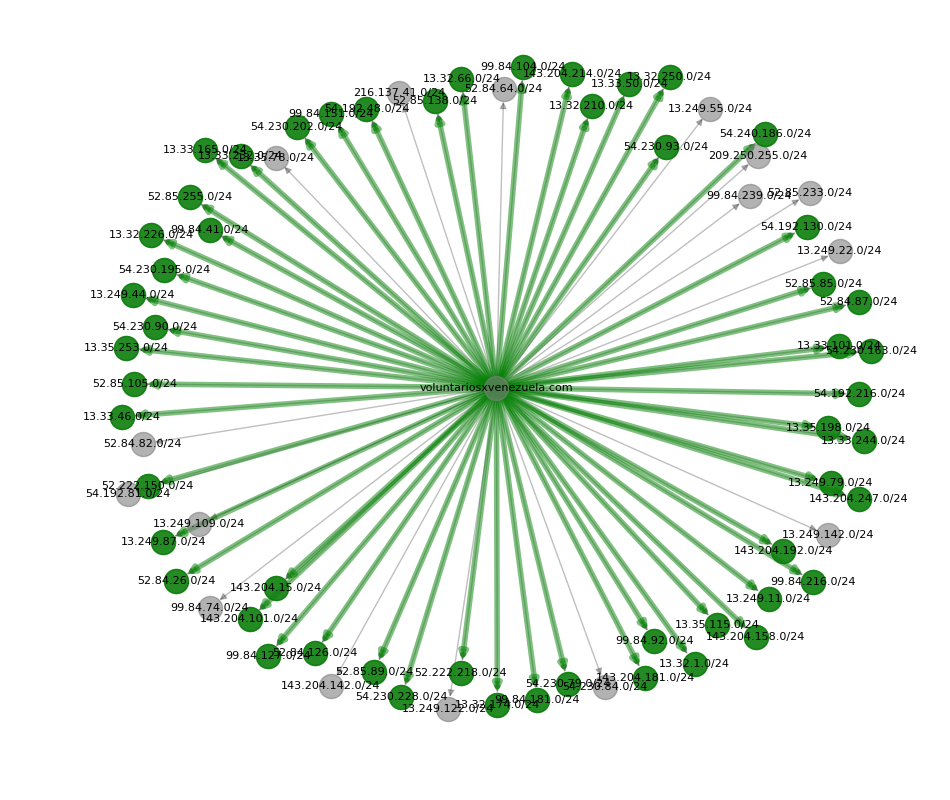

In [39]:
domain_app.display_graph()

## Use TLS to verify UNKNOWNs

At this stage we use TLS validation of certificates to check if an IP is valid for a domain

Checking IPs for voluntariosxvenezuela.com - 13.249.109.0/24
    Validating 13.249.109.75: VALID
Checking IPs for voluntariosxvenezuela.com - 13.249.122.0/24
    Validating 13.249.122.108: VALID
Checking IPs for voluntariosxvenezuela.com - 13.249.142.0/24
    Validating 13.249.142.75: VALID
Checking IPs for voluntariosxvenezuela.com - 13.249.22.0/24
    Validating 13.249.22.14: VALID
Checking IPs for voluntariosxvenezuela.com - 13.249.55.0/24
    Validating 13.249.55.107: VALID
Checking IPs for voluntariosxvenezuela.com - 13.35.78.0/24
    Validating 13.35.78.34: VALID
Checking IPs for voluntariosxvenezuela.com - 143.204.142.0/24
    Validating 143.204.142.49: VALID
Checking IPs for voluntariosxvenezuela.com - 209.250.255.0/24
    Validating 209.250.255.166: TimeoutError()
Checking IPs for voluntariosxvenezuela.com - 216.137.41.0/24
    Validating 216.137.41.175: VALID
Checking IPs for voluntariosxvenezuela.com - 52.84.64.0/24
    Validating 52.84.64.167: VALID
Checking IPs for volunta

<IPython.core.display.Javascript object>


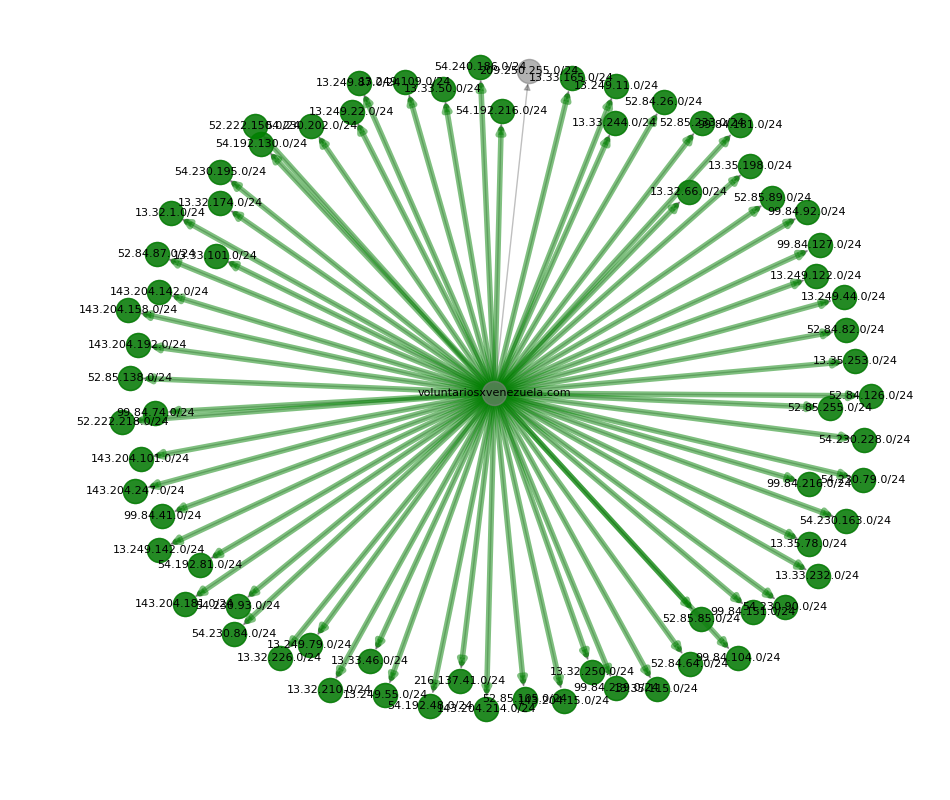

In [40]:
asyncio.run_coroutine_threadsafe(domain_app.tls_verify_unknowns(), LOOP).result()
domain_app.display_graph()

## Classify Measurements

In [41]:
from netanalysis.dns.analysis import classifier as dc

def analyze_measurements(domain: str, domain_graph, class_graph, results=None):
    measurements = dict()  # type: Dict[str, dns.DnsMeasurement]
    for u, v, data in domain_graph.edges(data=True):
        measurement = data.get("measurement")
        if not measurement:
            continue
        if measurement.trust_reason:
            continue
        if measurement.records[0].name.lower() != domain:
            continue
        measurements[measurement.measurement_id] = measurement


    for measurement in sorted(measurements.values(), key=lambda m: m.time):
        measurement_eval = dc.Evaluation(dc.EdgeClass.UNKNOWN, None)
        ips = []
        for record in measurement.records:
            try:
                ip = record.data.ip
                ips.append(ip)
            except AttributeError:
                continue
            
        for ip in ips:
            net = str(ipaddress.ip_network(ip).supernet(new_prefix=24))
            evaluation = class_graph[domain][net]["eval"]
            if evaluation.classification != dc.EdgeClass.UNKNOWN:
                measurement_eval = evaluation
                break
        if not results or measurement_eval.classification in results:
            print("{} {} {}, IPs: [{}] (DNS: {})".format(
                measurement.time,
                measurement.client_country,
                measurement_eval.classification.name,
                ", ".join(str(ip) for ip in ips),
                measurement.resolver_ip
            ))

analyze_measurements(domain_app.domain,
                     domain_app.domain_graph,
                     domain_app.classifier.class_graph,
                     results=[dc.EdgeClass.UNKNOWN, dc.EdgeClass.BAD])

2019-02-21 22:23:25 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 201.249.172.70)
2019-02-22 00:01:02 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 201.249.172.76)
2019-02-22 00:07:20 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 201.249.172.76)
2019-02-22 00:07:29 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 201.249.172.76)
2019-02-22 00:30:10 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 201.249.215.6)
2019-02-22 00:35:09 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 201.249.215.7)
2019-02-22 02:09:47 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 172.253.7.73)
2019-02-22 02:12:11 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 172.253.7.73)
2019-02-22 02:15:42 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 74.125.77.77)
2019-02-22 02:43:20 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 172.253.7.13)
2019-02-22 12:31:14 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 172.69.233.9)
2019-02-22 14:09:41 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 74.125.77.131)
2019-02-22 14:09:42 VE UNKNOWN, IPs: [209.250.255.166] (DNS: 74.125.77.131)
2019-02-22 15

## Analyze a country

<IPython.core.display.Javascript object>


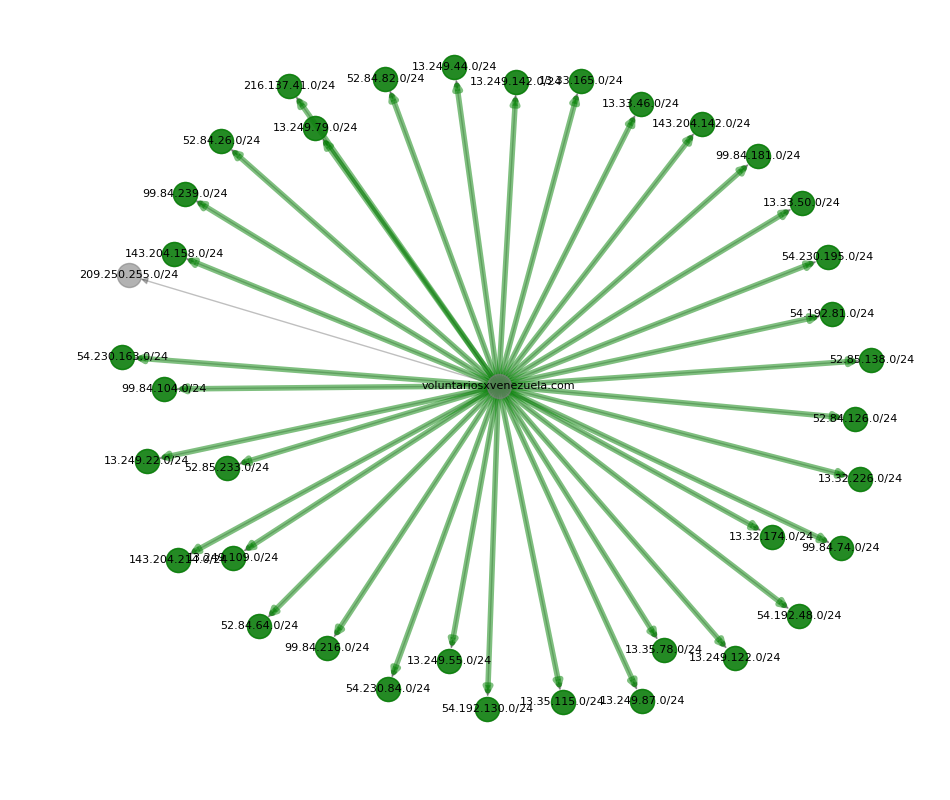

In [42]:
domain_app.display_graph(country="VE")

## Investigate an IP Address

In [31]:
from IPython.display import display
import ipywidgets as widgets
from netanalysis.dns.analysis import ip_info_widget
from netanalysis.ip import ip_info as ii

ip_info = ii.create_default_ip_info_service()
ip_tab = ip_info_widget.create_ip_info_widget(ip_info)
tabs = widgets.Tab()
tabs.set_title(0, "IP Info")
tabs.children = [ip_tab]
tabs